In [1]:
#1. exclude S2-only events
#2. S1 vs S2 uncorrected area - make a box cut around tritium data
#3. Cut low S1 area population, look at using eventviewer
#4. Drift time cut 
#5. Bad area cut

In [2]:
import uproot
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from scipy.optimize import curve_fit
import os

In [3]:
os.chdir(r"C:\Users\hpetr\Documents\University\Year 3\Bsc Project\Data")

#1. exclude S2-only events 
with uproot.open("ch3t_sr1_fixed.root") as f:
    arr = f["Events"].arrays(cut = 'S1_corrected_area > 0', library = 'pd')
arr.head()

,runID,evtID,S2_area,S2_btm_area,S2_top_area,S2_TBA,S2_corrected_area,S2_XY_corrected_area,S2_width_ns,S2_peakAmp,...,S2_n_saturated,has_good_S1,drift_time,S1_area,S1_corrected_area,evt_total_area,evt_bad_area,evt_bad_e_area,evt_bad_ph_area,evt_bad_oth_area
0,8136,65034,118.0,49.244331,4.825457e+01,-0.010151,9.870134e+01,0.002266,2870.0,0.158147,...,0.0,True,1880.00000,2295.077637,2384.228760,2.669723e+03,277.044191,2.625722e+02,112.073274,2.121996e-314
1,8136,65058,742.0,131640.343750,2.982435e+05,0.387554,3.297500e+06,15.089437,5360.0,298.280945,...,0.0,True,331150.03125,5893.939453,5994.260742,5.819314e+05,150035.855259,5.793474e+05,528.764211,4.347748e+01
2,8136,65060,552.0,677225.187500,1.202335e+06,0.279379,3.297500e+06,67.300720,9060.0,1371.740112,...,3.0,True,331150.03125,5893.939453,5994.260742,2.781278e+06,896683.535831,2.774540e+06,474.216490,1.230250e+03
3,8136,65063,806.0,101785.929688,2.272925e+05,0.381388,2.183503e+06,11.366468,3960.0,220.868744,...,0.0,True,23620.00000,2942.413818,3231.704346,5.545283e+05,223988.855204,5.524404e+05,567.587461,5.960238e+01
4,8136,65070,640.0,197790.750000,4.263606e+05,0.366209,6.481201e+05,20.348724,4140.0,459.318115,...,0.0,True,9920.00000,1746.073730,1825.996216,6.835850e+05,57687.135598,6.813085e+05,438.078742,9.228541e+01


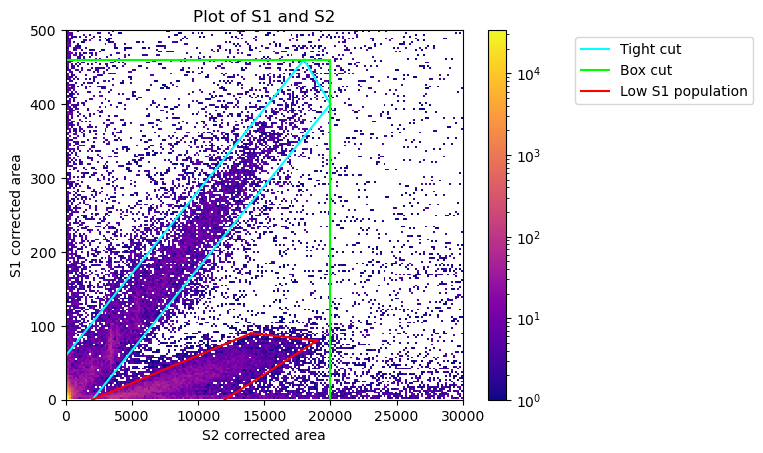

In [240]:
fig, ax = plt.subplots()
conditions= (arr['S1_corrected_area']<500) & (arr['S2_corrected_area']<30000)

#Tight cut
line1 = plt.Line2D((2000, 20000), (0, 400), color = 'cyan', label="Tight cut")
line2 = plt.Line2D((0, 18000), (60, 460), color = 'cyan')
line3 = plt.Line2D((20000, 18000), (400, 460), color = 'cyan')

#Box cut
line4=plt.Line2D((0,20000),(460,460), color="lime", label = "Box cut")
line5 = plt.Line2D((20000, 20000), (460, 0), color = 'lime')

#Low S1 population
line6=plt.Line2D((2000,14000),(0,90), color="red", label = "Low S1 population")
line7 = plt.Line2D((12000, 19000), (0,80), color = 'red')
line8 = plt.Line2D((14000, 19000), (90,80), color = 'red')


#Plot
h = ax.hist2d(arr['S2_corrected_area'].to_numpy()[conditions], 
              arr['S1_corrected_area'].to_numpy()[conditions],  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

ax.add_line(line1)
ax.add_line(line2)
ax.add_line(line3)

ax.add_line(line4)
ax.add_line(line5)

ax.add_line(line6)
ax.add_line(line7)
ax.add_line(line8)

plt.ylim(0, 500)
plt.xlim(0, 30000)
plt.xlabel('S2 corrected area')
plt.ylabel('S1 corrected area')
plt.title('Plot of S1 and S2')
plt.legend(loc='upper right',bbox_to_anchor=(1.75, 1))
plt.show()

#for line1
m = 400 / 18000
c1 = -40 

#for line2
m = 400 / 18000
c2 = 60 


#box cut around this
#plot negative drift time vs radius^2 (from x^2 + y^of 2 of S2)

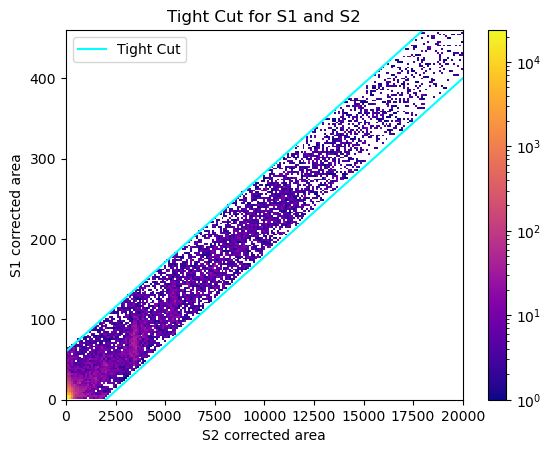

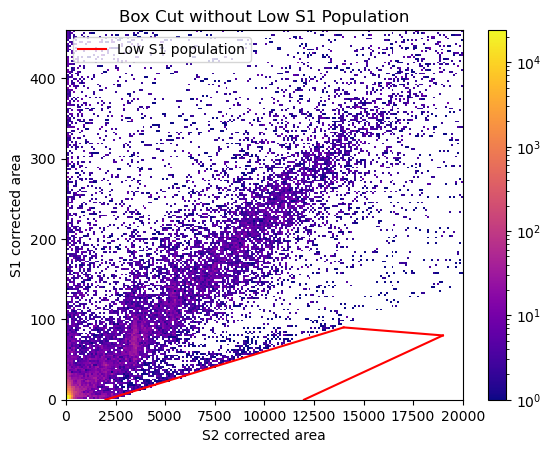

In [160]:
def line(x, m, c):
    y = (m * x) + c
    return y

#Tight cut
fig, ax = plt.subplots()
conditions = (arr['S1_corrected_area']<line(arr['S2_corrected_area'], m, c2)) & (arr['S1_corrected_area']>line(arr['S2_corrected_area'], m, c1))  & (arr['S2_corrected_area']< 20000) &(arr['S1_corrected_area']<460) 


line1 = plt.Line2D((2000, 20000), (0, 400), color = 'cyan', label="Tight Cut")
line2 = plt.Line2D((0, 18000), (60, 460), color = 'cyan')
#line3 = plt.Line2D((20000, 18000), (400, 460), color = 'cyan')

h = ax.hist2d(arr['S2_corrected_area'].to_numpy()[conditions], 
              arr['S1_corrected_area'].to_numpy()[conditions],  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)
ax.add_line(line1)
ax.add_line(line2)
#ax.add_line(line3)
plt.xlabel('S2 corrected area')
plt.ylabel('S1 corrected area')
plt.title('Tight Cut for S1 and S2')
plt.ylim(0, 460)
plt.xlim(0, 20000)
plt.legend()
plt.show()

#3. Cut low S1 area population
fig, ax = plt.subplots()
conditions = (arr['S1_corrected_area']>line(arr['S2_corrected_area'], 0.008, -18)) & (arr['S2_corrected_area']< 20000) &(arr['S1_corrected_area']<460)


line6=plt.Line2D((2000,14000),(0,90), color="red", label = "Low S1 population")
line7 = plt.Line2D((12000, 19000), (0,80), color = 'red')
line8 = plt.Line2D((14000, 19000), (90,80), color = 'red')

h = ax.hist2d(arr['S2_corrected_area'].to_numpy()[conditions], 
              arr['S1_corrected_area'].to_numpy()[conditions],  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlabel('S2 corrected area')
plt.ylabel('S1 corrected area')
plt.title('Box Cut without Low S1 Population')
plt.ylim(0, 460)
plt.xlim(0, 20000)
ax.add_line(line6)
ax.add_line(line7)
ax.add_line(line8)
plt.legend(loc="upper left")
plt.show()

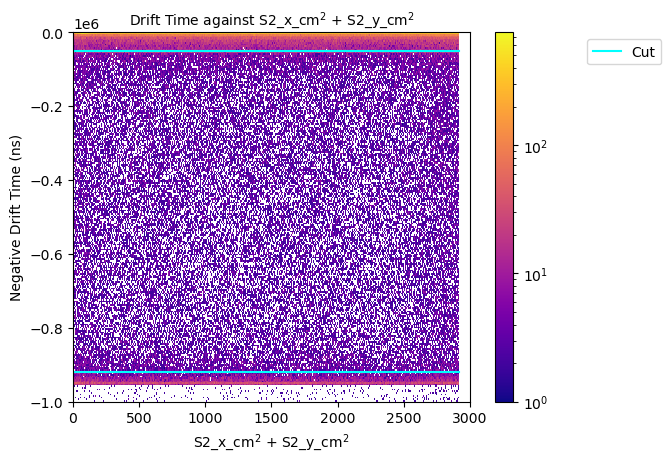

In [359]:
#3. Drift time against S2_x_cm^2 + S2_y_cm^2
#Nothing cut so far
#Note: data points after 2916 on x-axis seems to have already been cut for us

x2y2= np.square(arr['S2_x_cm'])+np.square(arr['S2_y_cm'])
negdt=np.multiply(arr['drift_time'],-1)

fig, ax = plt.subplots()
#Straight cut lines
line1 = plt.Line2D((0, 2916), (-0.05e6, -0.05e6), color = 'cyan', label="Cut")
line2 = plt.Line2D((0, 2916), (-0.92e6, -0.92e6), color = 'cyan')

h = ax.hist2d(x2y2,negdt,bins=1000, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)

plt.xlim(0,3000)
plt.ylim(-1e6,0)

ax.add_line(line1)
ax.add_line(line2)

plt.xlabel('S2_x_cm$^{2}$ + S2_y_cm$^{2}$')
plt.ylabel('Negative Drift Time (ns)')
plt.title('Drift Time against S2_x_cm$^{2}$ + S2_y_cm$^{2}$',size=10)
plt.legend(loc='upper right',bbox_to_anchor=(1.5, 1))
plt.show()

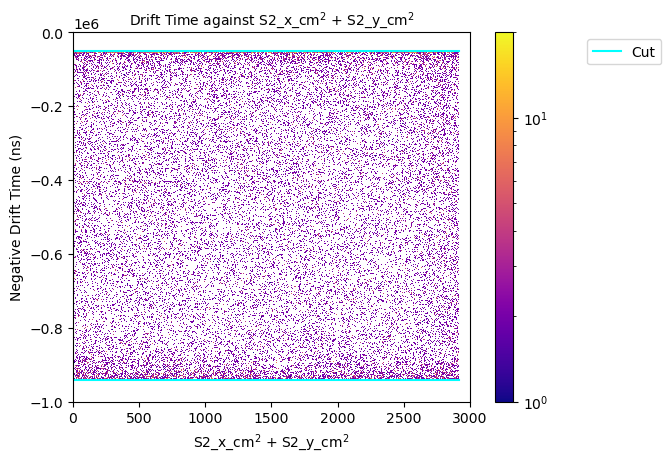

In [368]:
#3 Drift time against S2_x_cm^2 + S2_y_cm^2 WITH cuts
fig, ax = plt.subplots()
conditions= (negdt>-0.94e6) & (negdt<-0.05e6) #Cutting

line1 = plt.Line2D((0, 2916), (-0.05e6, -0.05e6), color = 'cyan', label="Cut")
line2 = plt.Line2D((0, 2916), (-0.94e6, -0.94e6), color = 'cyan')


h = ax.hist2d(x2y2.to_numpy()[conditions],negdt.to_numpy()[conditions],               
              bins=1000, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)
plt.xlim(0,3000)
plt.ylim(-1e6,0)
ax.add_line(line1)
ax.add_line(line2)
plt.xlabel('S2_x_cm$^{2}$ + S2_y_cm$^{2}$')
plt.ylabel('Negative Drift Time (ns)')
plt.title('Drift Time against S2_x_cm$^{2}$ + S2_y_cm$^{2}$',size=10)
plt.legend(loc='upper right',bbox_to_anchor=(1.5, 1))
plt.show()

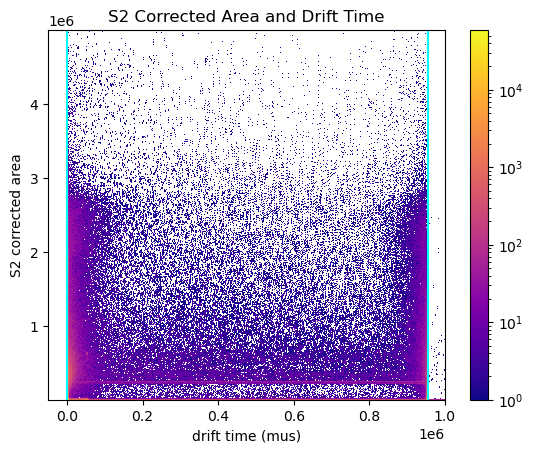

In [243]:
#4. Drift time cut

fig, ax = plt.subplots()
conditions = (arr['drift_time']<1e6) & (arr['S2_corrected_area']< 0.5e7)

line1 = plt.Line2D((0, 0), (0, 5e6), color = 'cyan')
line2 = plt.Line2D((955000, 955000), (0, 5e6), color = 'cyan')

h = ax.hist2d(arr['drift_time'].to_numpy()[conditions],
               arr['S2_corrected_area'].to_numpy()[conditions],  
              bins=500, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)
#plt.ylim(0, 500)
plt.xlim(-50000, 1000000)
ax.add_line(line1)
ax.add_line(line2)
plt.xlabel('drift time (mus)')
plt.ylabel('S2 corrected area')
plt.title('S2 Corrected Area and Drift Time')
plt.show()

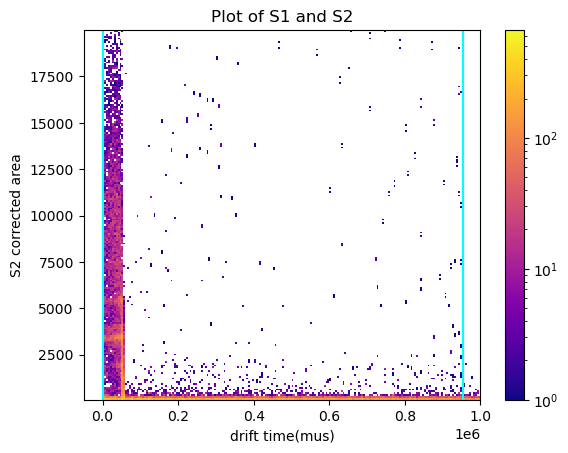

In [304]:
#4. Drift time cut

#applying S1 and S2 cuts for tritium 
fig, ax = plt.subplots()
conditions = (arr['S1_corrected_area']<line(arr['S2_corrected_area'], m, c2)) & (arr['S1_corrected_area']>line(arr['S2_corrected_area'], m, c1)) & (arr['S2_corrected_area']< 20000) & (arr['drift_time']<1e6) & (arr['S2_corrected_area']< 0.5e7) 

line1 = plt.Line2D((0, 0), (0, 5e6), color = 'cyan')
line2 = plt.Line2D((955000, 955000), (0, 5e6), color = 'cyan')

h = ax.hist2d(arr['drift_time'].to_numpy()[conditions],
               arr['S2_corrected_area'].to_numpy()[conditions],  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)
#plt.ylim(0, 500)
plt.xlim(-50000, 1e6)
ax.add_line(line1)
ax.add_line(line2)
plt.xlabel('drift time(mus)')
plt.ylabel('S2 corrected area')
plt.title('Plot of S1 and S2')
plt.show()

#remove gate signal up to 60,000 microseconds

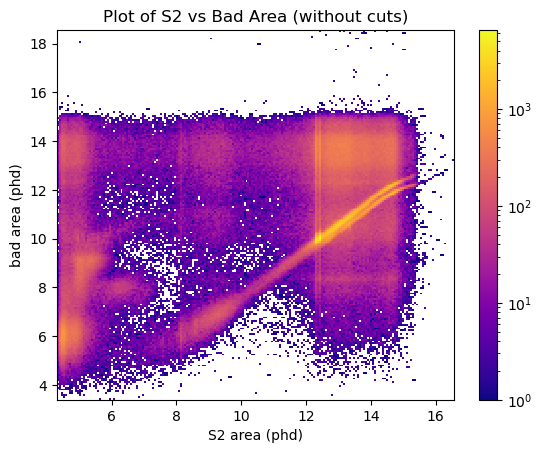

In [90]:
#5. Bad area cut

x = np.log(arr['S2_corrected_area'])
y = np.log(arr['evt_bad_area'])

fig, ax = plt.subplots()

h = ax.hist2d(x, 
              y,  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm(), alpha=1)
fig.colorbar(h[3], ax=ax)
plt.xlabel('S2 area (phd)')
plt.ylabel('bad area (phd)')
plt.title('Plot of S2 vs Bad Area (without cuts)')
plt.show()

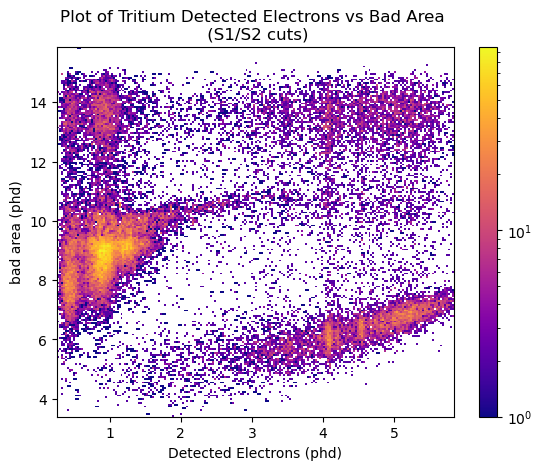

In [103]:
#applying S1 and S2 cuts for tritium 
conditions = (arr['S1_corrected_area']<line(arr['S2_corrected_area'], m, c2)) & (arr['S1_corrected_area']>line(arr['S2_corrected_area'], m, c1)) & (arr['S2_corrected_area']< 20000) & (arr['drift_time']<1e6) & (arr['S2_corrected_area']< 0.5e7)

x = arr['S2_corrected_area'].to_numpy()[conditions]
x = np.log(x / 58.5)
y = arr['evt_bad_area'].to_numpy()[conditions]
y = np.log(y)

fig, ax = plt.subplots()

h = ax.hist2d(x, 
              y,  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm(), alpha=1)
fig.colorbar(h[3], ax=ax)
plt.xlabel('Detected Electrons (phd)')
plt.ylabel('bad area (phd)')
plt.title('Plot of Tritium Detected Electrons vs Bad Area \n (S1/S2 cuts)')
plt.show()

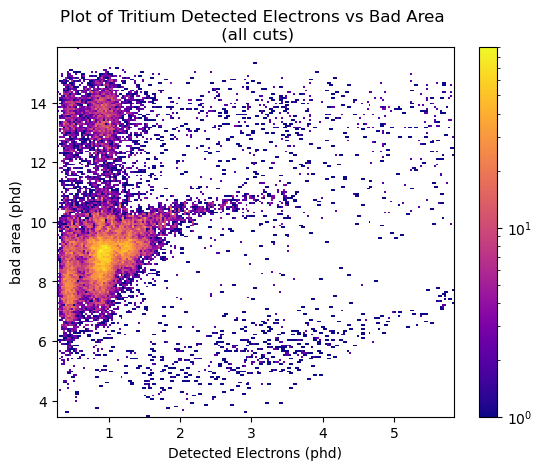

In [102]:
#adding in drift time cut
conditions = (arr['S1_corrected_area']<line(arr['S2_corrected_area'], m, c2)) & (arr['S1_corrected_area']>line(arr['S2_corrected_area'], m, c1)) & (arr['S2_corrected_area']< 20000) & (arr['drift_time']<1e6) & (arr['S2_corrected_area']< 0.5e7) & (arr['drift_time']> 60000)

x = arr['S2_corrected_area'].to_numpy()[conditions]
x = np.log(x / 58.5)
y = arr['evt_bad_area'].to_numpy()[conditions]
y = np.log(y)

fig, ax = plt.subplots()

h = ax.hist2d(x, 
              y,  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm(), alpha=1)
fig.colorbar(h[3], ax=ax)
plt.xlabel('Detected Electrons (phd)')
plt.ylabel('bad area (phd)')
plt.title('Plot of Tritium Detected Electrons vs Bad Area \n (all cuts)')
plt.show()